In [1]:
import os
os.chdir("/Users/jacksonwalters/Documents/GitHub/enefit-kaggle/predict-energy-behavior-of-prosumers/")
!ls

client.csv                            gas_prices.csv
county_id_to_name_map.json            historical_weather.csv
electricity_prices.csv                public_timeseries_testing_util.py
enefit                                train.csv
example_test_files                    weather_station_to_county_mapping.csv
forecast_weather.csv


In [3]:
import pandas as pd
import numpy as np
from load_data import merged_df

In [34]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.8.0


In [4]:
df = merged_df()

loading train data...
loading gas_prices...
loading electricity_prices...
loading forecast_weather...
merging train and gas_prices...
merging electricity_prices...
merging forecast_weather...


In [24]:
df = df[:100_000]

In [25]:
#test/train split
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [26]:
#drop the target column 
train_labels = train_dataset['target']
test_labels = test_dataset['target']

train_features = train_dataset.drop(columns=['target'])
test_features = test_dataset.drop(columns=['target'])

In [27]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [28]:
normalizer.adapt(np.array(train_features))

2023-12-16 13:02:57.754671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-16 13:02:57.768400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [29]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 4.00e+00  0.00e+00  1.00e+00  1.00e+00  1.63e+09  1.00e+00  2.96e+03
   1.50e+01  1.63e+09  4.56e+01  4.63e+01  9.70e+01  5.97e+01  2.77e+01
   1.26e+01  7.03e+00  0.00e+00  2.13e-01  8.94e-02  2.29e-01  2.20e+00
  -1.07e+01  8.52e-05]]

Normalized: [[-0.67 -1.01 -0.94  1.   -1.5  -1.5  -1.5  -0.79 -1.5  -1.31 -1.23  0.15
   1.53  1.36  0.41 -0.26 -0.54  0.13 -0.74 -0.68 -0.69 -2.28  0.27]]


In [30]:
train_features.columns

Index(['county', 'is_business', 'product_type', 'is_consumption',
       'prediction_datetime', 'data_block_id', 'row_id', 'prediction_unit_id',
       'forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'euros_per_mwh', 'latitude', 'longitude', 'temperature', 'dewpoint',
       'cloudcover_high', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'total_precipitation'],
      dtype='object')

In [35]:
prediction_datetime = np.array(train_features['prediction_datetime'])

prediction_datetime_normalizer = layers.Normalization(input_shape=[1,], axis=None)
prediction_datetime_normalizer.adapt(prediction_datetime)

2023-12-16 13:07:13.130870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-16 13:07:13.143040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [36]:
prediction_datetime_model = tf.keras.Sequential([
    prediction_datetime_normalizer,
    layers.Dense(units=1)
])

prediction_datetime_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [37]:
prediction_datetime_model.predict(prediction_datetime[:10])

2023-12-16 13:08:31.261344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.17491405],
       [-0.04474546],
       [ 0.01008807],
       [ 0.11991782],
       [ 0.17491405],
       [ 0.01008807],
       [-0.15457521],
       [ 0.17491405],
       [-0.04474546],
       [ 0.01008807]], dtype=float32)

In [38]:
prediction_datetime_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [81]:
%%time
history = prediction_datetime_model.fit(
    train_features['prediction_datetime'],
    train_labels,
    epochs=3,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/3
2000/2000 [==============================] - 9s 4ms/step - loss: 158.8768 - val_loss: 161.5793
Epoch 2/3
2000/2000 [==============================] - 9s 4ms/step - loss: 158.8746 - val_loss: 161.5427
Epoch 3/3
2000/2000 [==============================] - 9s 4ms/step - loss: 158.8784 - val_loss: 161.5459
CPU times: user 22.1 s, sys: 7.71 s, total: 29.8 s
Wall time: 25.9 s


In [82]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
0,158.876785,161.579269,0
1,158.874619,161.542679,1
2,158.878357,161.545944,2


In [76]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 200])
  plt.xlabel('Epoch')
  plt.ylabel('Error [target]')
  plt.legend()
  plt.grid(True)

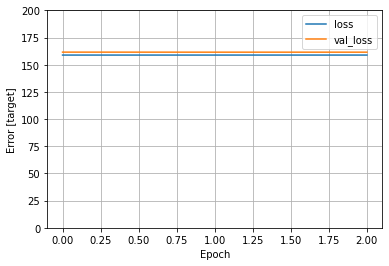

In [83]:
plot_loss(history)

In [59]:
test_results = {}

test_results['prediction_datetime_model'] = prediction_datetime_model.evaluate(
    test_features['prediction_datetime'],
    test_labels, verbose=0)

In [67]:
x = tf.linspace(min(df['prediction_datetime']), max(df['prediction_datetime']), 100_000)
y = prediction_datetime_model.predict(x)

2023-12-16 13:18:03.489971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [62]:
def plot_prediction_datetime(x, y):
  plt.scatter(train_features['prediction_datetime'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('prediction_datetime')
  plt.ylabel('target')
  plt.legend()

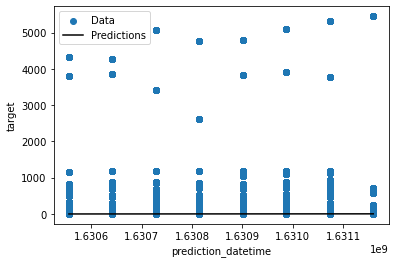

In [68]:
plot_prediction_datetime(x, y)

In [69]:
#initalize a linear model with multiple variables
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [70]:
linear_model.predict(train_features[:10])

2023-12-16 13:20:04.052159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[-1.8305392 ],
       [ 0.94154537],
       [ 0.56011504],
       [-0.01794962],
       [-1.2933463 ],
       [ 1.0016675 ],
       [ 0.43741804],
       [-0.13658412],
       [ 0.8922932 ],
       [-0.8714205 ]], dtype=float32)

In [71]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(23, 1) dtype=float32, numpy=
array([[-0.0335803 ],
       [-0.063766  ],
       [ 0.02608466],
       [ 0.00498104],
       [ 0.49331295],
       [ 0.4149927 ],
       [-0.4322486 ],
       [ 0.45093858],
       [ 0.04843426],
       [-0.09107506],
       [ 0.10054481],
       [-0.47092497],
       [-0.24409223],
       [-0.27260303],
       [-0.10152125],
       [-0.2858603 ],
       [-0.11807334],
       [-0.17977631],
       [ 0.05709934],
       [ 0.15478528],
       [ 0.15475929],
       [-0.12086391],
       [-0.10384119]], dtype=float32)>

In [72]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [84]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=3,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/3
2000/2000 [==============================] - 9s 4ms/step - loss: 145.6714 - val_loss: 148.1907
Epoch 2/3
2000/2000 [==============================] - 9s 4ms/step - loss: 145.6608 - val_loss: 148.1837
Epoch 3/3
2000/2000 [==============================] - 9s 4ms/step - loss: 145.6639 - val_loss: 148.0331
CPU times: user 22.3 s, sys: 7.75 s, total: 30 s
Wall time: 26.2 s


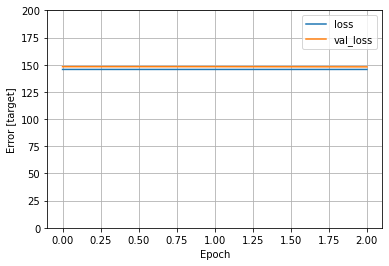

In [85]:
plot_loss(history)

In [86]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [87]:
#switch to deep learning

In [88]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [89]:
dnn_prediction_datetime_model = build_and_compile_model(prediction_datetime_normalizer)

In [90]:
dnn_prediction_datetime_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [92]:
%%time
history = dnn_prediction_datetime_model.fit(
    train_features['prediction_datetime'],
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=1)

2023-12-16 13:30:59.519893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1992/2000 [============================>.] - ETA: 0s - loss: 159.0435

2023-12-16 13:31:08.926953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2000/2000 [==============================] - 11s 5ms/step - loss: 158.8807 - val_loss: 161.5528
CPU times: user 8.59 s, sys: 2.24 s, total: 10.8 s
Wall time: 10.8 s


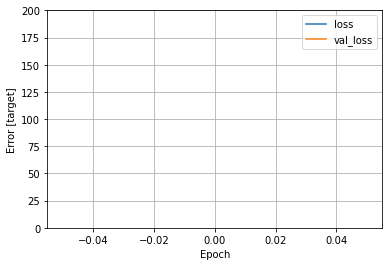

In [93]:
plot_loss(history)

In [95]:
x = tf.linspace(min(df['prediction_datetime']), max(df['prediction_datetime']), 100_000)
y = dnn_prediction_datetime_model.predict(x)

2023-12-16 13:32:06.269751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


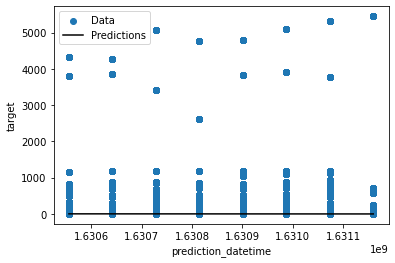

In [96]:
plot_prediction_datetime(x, y)

In [98]:
test_results['dnn_prediction_datetime_model'] = dnn_prediction_datetime_model.evaluate(
    test_features['prediction_datetime'], test_labels,
    verbose=1)

625/625 [==============================] - 2s 4ms/step - loss: 160.0013


In [100]:
#build the full DNN on multiple inputs

In [99]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 23)               47        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                1536      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,808
Trainable params: 5,761
Non-trainable params: 47
_________________________________________________________________


In [105]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=2)

Epoch 1/2
2000/2000 [==============================] - 10s 5ms/step - loss: 124.8935 - val_loss: 124.4837
Epoch 2/2
2000/2000 [==============================] - 10s 5ms/step - loss: 121.2694 - val_loss: 120.1958
CPU times: user 16.6 s, sys: 4.33 s, total: 20.9 s
Wall time: 19.6 s


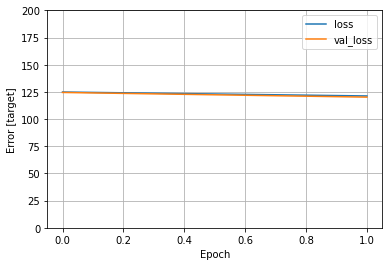

In [106]:
plot_loss(history)

In [107]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=1)

625/625 [==============================] - 2s 4ms/step - loss: 120.1335


In [108]:
pd.DataFrame(test_results, index=['Mean absolute error [target]']).T

,Mean absolute error [target]
prediction_datetime_model,160.003769
linear_model,146.869049
dnn_prediction_datetime_model,160.001343
dnn_model,120.133514


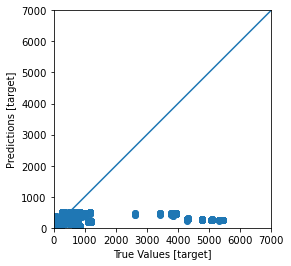

In [113]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [target]')
plt.ylabel('Predictions [target]')
lims = [0, 7_000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [135]:
len(test_features.columns.values)

23

In [132]:
dnn_model.predict(test_features[:100]).flatten()

array([ 1.8582939e-01, -1.0157134e-01, -1.2930848e-01, -2.0171419e-02,
        2.4047683e-01, -4.4691110e-01,  2.9421115e-01,  2.5153279e-01,
        1.1984800e-01, -1.1133924e-02,  1.3454746e-01,  2.0303749e-01,
        1.7565416e-01,  6.1279631e-01,  3.1572008e-01,  3.6433649e-01,
       -1.0351540e-01,  3.0958915e-01,  2.7282262e-01,  3.9511561e-01,
        5.3552771e-01,  5.4885936e-01,  3.2644320e-01,  3.6373663e-01,
        1.6045141e+01,  1.6122757e+01,  1.6159733e+01,  1.5862016e+01,
        1.6487352e+01,  1.6438038e+01,  1.6664373e+01,  1.6585262e+01,
        1.5648124e+01,  1.6847864e+01,  1.6461058e+01,  1.7108765e+01,
        1.7172663e+01,  1.7608461e+01,  1.7118399e+01,  1.6696369e+01,
        1.7765348e+01,  1.7833607e+01,  1.5875935e+01,  1.8796858e+01,
        1.7917669e+01,  1.9645224e+01,  1.6954189e+01,  1.6598103e+01,
        5.7232127e-02, -2.4070516e-02,  1.0577653e-01,  1.4560817e-01,
        2.7461934e-01,  4.5177150e-01,  3.3392653e-02, -2.0227267e-01,
      

In [138]:
# save the model to disk
import pickle
dnn_model_filename = '../models/dnn_model.sav'
pickle.dump(dnn_model, open(dnn_model_filename, 'wb'))

INFO:tensorflow:Assets written to: ram://d49cfd09-aff7-4a26-ac68-3fc80c57c255/assets


2023-12-16 13:49:53.104132: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [139]:
#save model using keras
dnn_model.save('../models/dnn_model.keras')